# DNN Practical: Ag Detection by Muon Spectroscopy

In this notebook, we attempt to solve a real problem in physics using a fully connected DNN.

We have a set of spectra from Muon spectroscopy experiments, from which we would like to detect whether or not a certain element is present in a sample. In this notebook, we are going to train a neural network to detect the presence of Ag. Through this practice, we will encounter and overcome a pitfall in deep learning known as **class imbalance**. We will also explore **early stopping** and saving checkpoints from the best performing model.

## About the data

The data in this example is generated from simulated muon spectroscopy experiments. First the data was generated for each individual element by simulating the spectral emmission lines of that element. Then for the mixed coumpounds the different elemental spectra were mixed in proportion to how much of that element is present in the compound.

In [5]:
!wget https://zenodo.org/records/14230642/files/ag-muon-data-tight.pkl

--2024-11-29 11:13:23--  https://zenodo.org/records/14230642/files/ag-muon-data-tight.pkl
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.45.92, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1677187148 (1.6G) [application/octet-stream]
Saving to: ‘ag-muon-data-tight.pkl’

ag-muon-data-tight. 100%[===================>]   1.56G  19.6MB/s    in 86s     

2024-11-29 11:14:50 (18.6 MB/s) - ‘ag-muon-data-tight.pkl’ saved [1677187148/1677187148]



In [11]:
# torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.datasets as datasets

# helpers
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# need some certainty in data processing
np.random.seed(0)

from tqdm.notebook import trange, tqdm

---

# The dataset

### Read raw data

The raw data, which include the constituent elements and the Muon spectra of the samples, are stored in the pickle file `muon/Ag_muon_data.pkl`. We load this file into a `pandas` dataframe and take a quick look.

In [6]:
# read data
df = pd.read_pickle('ag-muon-data-tight.pkl')
#print dimensions
print('Number of samples in the dataset: %d' % len(df['Spectra']))
print('Length of spectra for each sample: %d' % len(df['Spectra'][0]))

# print the first few data
df.head(n=5)

Number of samples in the dataset: 138613
Length of spectra for each sample: 1000


,Elements,oh,c,Spectra
8877,"[Si, Fe, Sb, Bi]",0,"[0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 132.19327401887..."
88555,"[Sb, Fe, Bi]",0,"[0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 106.91719527298..."
111153,"[Si, Sb]",0,"[0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 108.04741040971..."
27279,"[Fe, Cu, Bi]",0,"[0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 106.84704457348..."
26419,"[Si, Fe]",0,"[0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 100.82180543319..."


In the above table, the `Elements` and the `Spectra` columns show respectively the elements and the spectra of the samples. There are 138,613 samples in the dataset, and each spectrum is a series of 1000 positive reals.

To get a feel for the complexity of picking out signals with Ag in multinary samples, we can plot some random spectra for three representative cases:

* no Ag
* pure Ag
* Ag-Si binary

Note that we are plotting only the first part of each spectrum. Change `[0:150]` to `[:]` to show the full spectra.

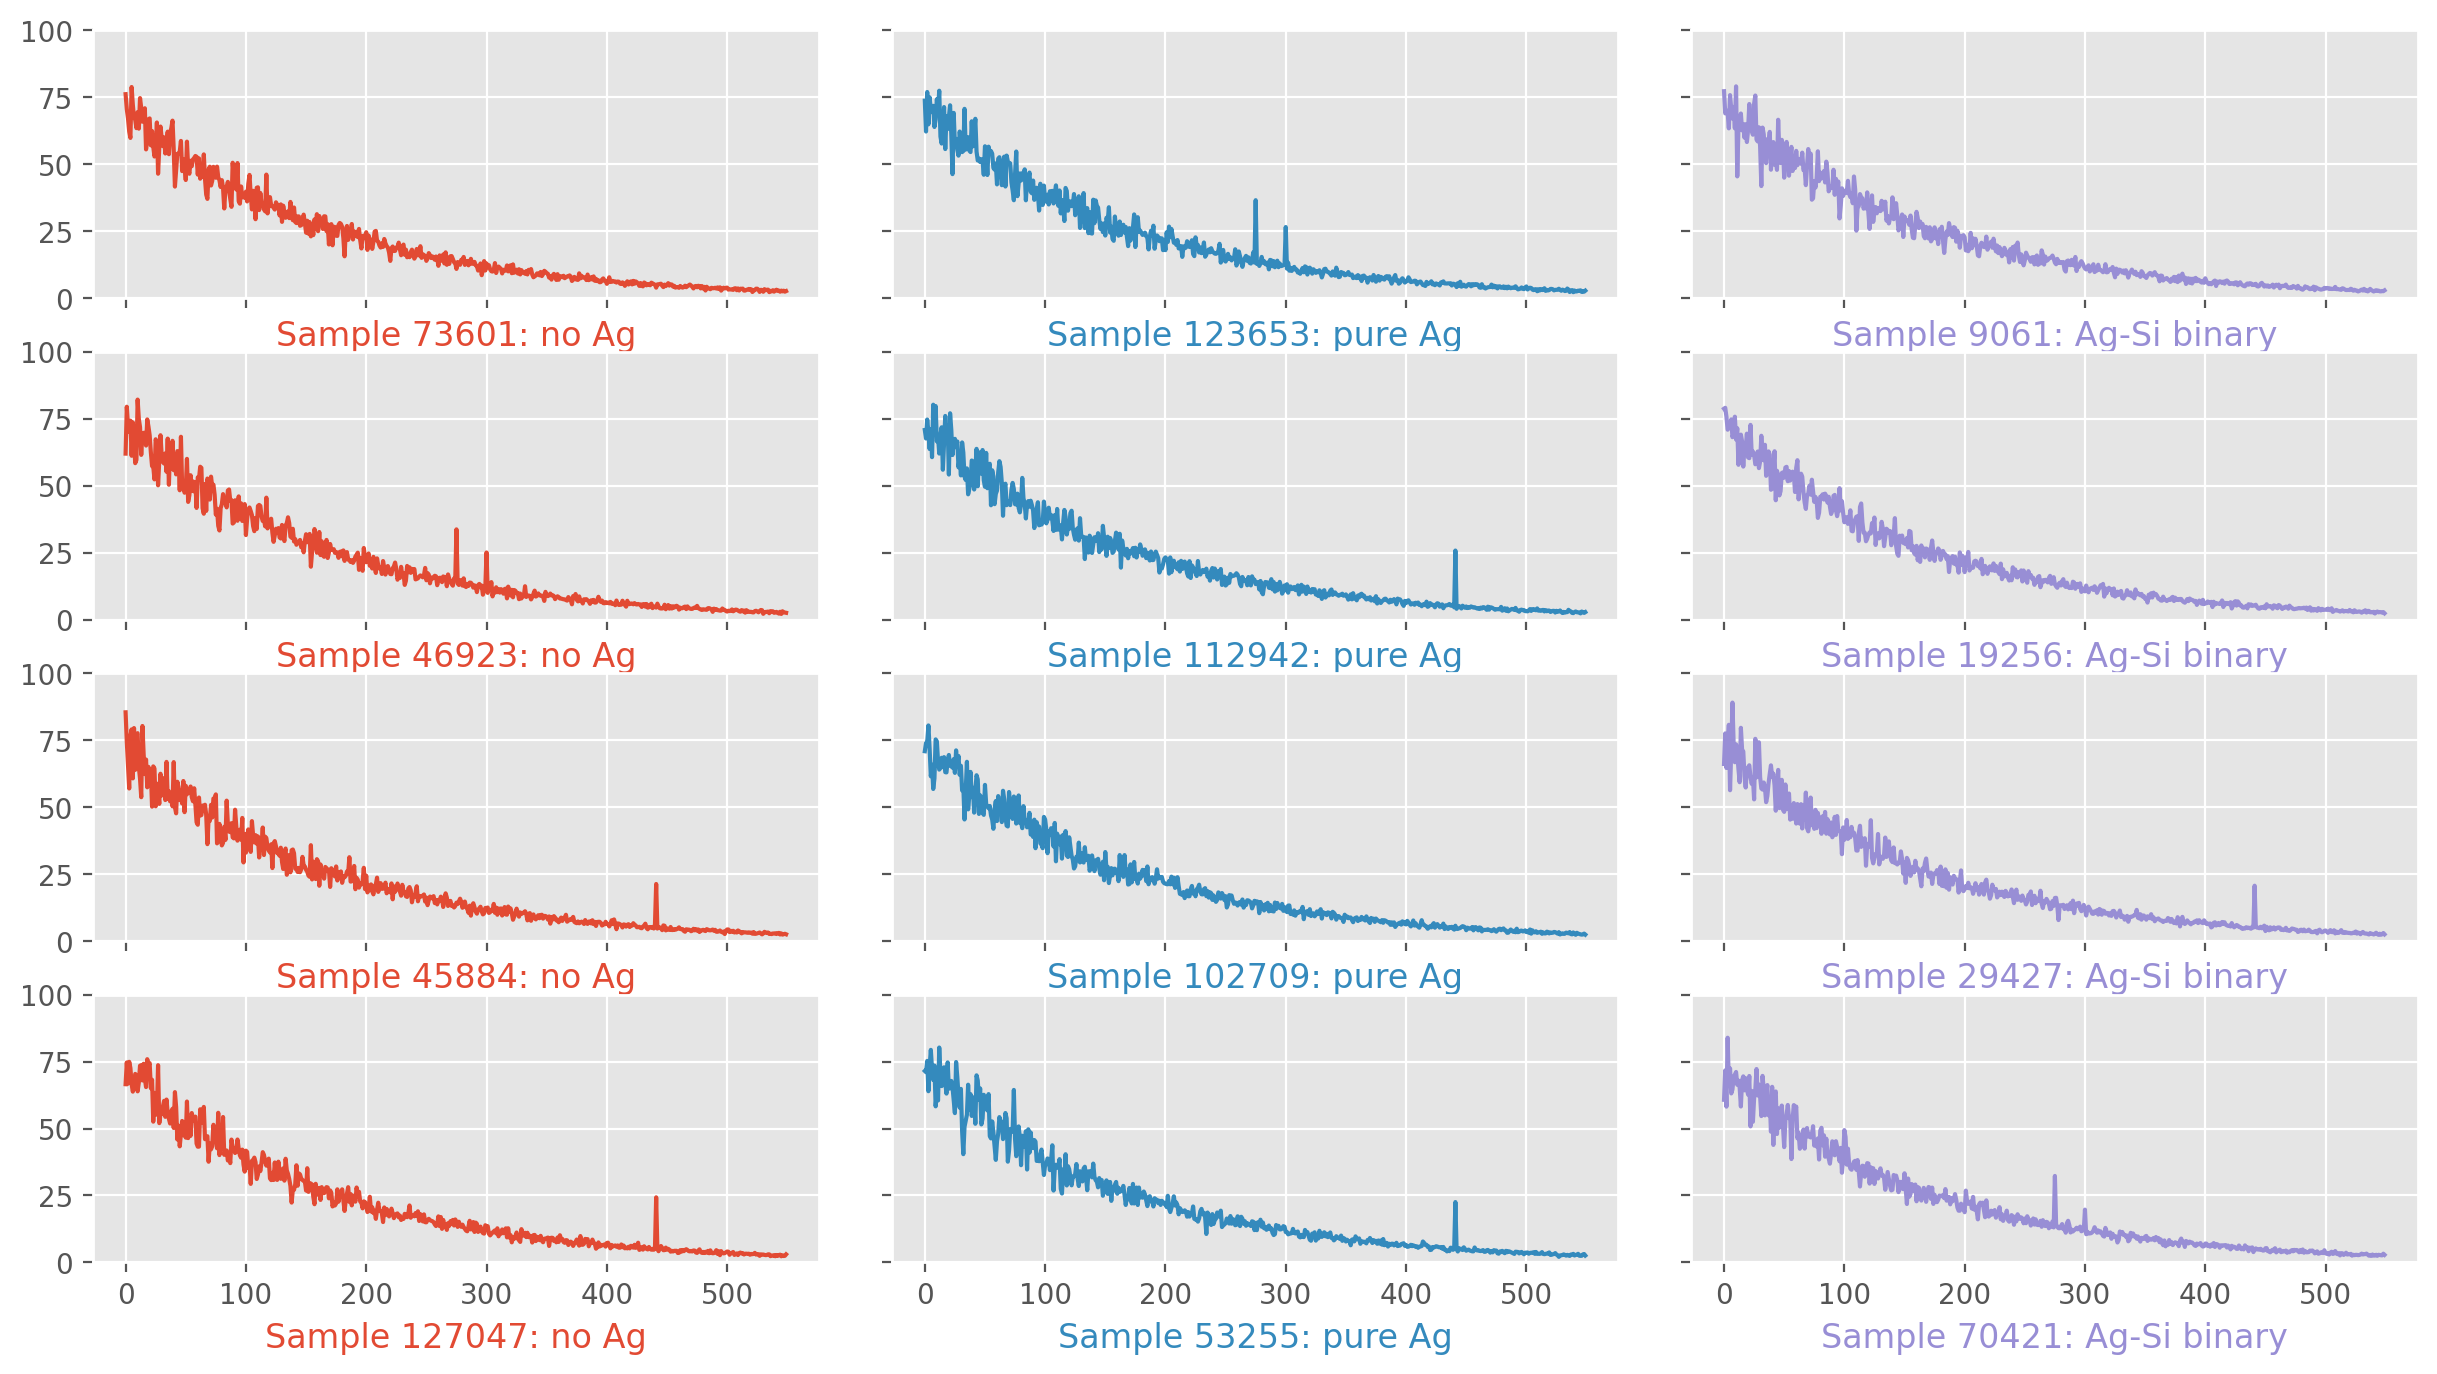

In [7]:
# conditions to select data
conditions = [
# no Ag
('no Ag', np.where(['Ag' not in elements for elements in df['Elements']])[0]),
# pure Ag
('pure Ag', np.where([['Ag'] == elements for elements in df['Elements']])[0]),
# Ag-Si
('Ag-Si binary', np.where([['Ag', 'Si'] == elements for elements in df['Elements']])[0])
]

# plot
ncond = len(conditions)
nplot = 4 # number of plots per condition
fig, axs = plt.subplots(nplot, ncond, dpi=200, figsize=(ncond * 5, nplot * 2), sharex=True, sharey=True)
plt.subplots_adjust(wspace=.1, hspace=.2)
for icond, cond in enumerate(conditions):
    for iplot, idata in enumerate(np.random.choice(cond[1], nplot)):
        axs[iplot, icond].plot(df['Spectra'][idata][150:700], c='C%d' % icond)
        axs[iplot, icond].set_xlabel('Sample %d: %s' % (idata, cond[0]), c='C%d' % icond)
        axs[iplot, icond].set_ylim(0, 100)

### Extract training data

The input data for our network will be the `Spectra` column, and we can use the `to_list()` method to convert it to a numpy array. The output data for our network will be a binary-valued one-hot vector: 0 for no Ag in the sample and 1 otherwise. One-hot encoding can be achieved by a simple for-loop. Also, it is important to normalise each spectrum between 0 and 1.

In [8]:
###### input ######
limit = -1
# convert the 'Spectra' column to numpy
train_x = np.array(df['Spectra'].to_list())[:limit]
# normalise each spectrum to [0, 1]
train_x /= np.max(train_x, axis=1)[:, np.newaxis]

###### output ######
# one-hot encoding: whether Ag is in 'Elements'
train_y = np.array(['Ag' in elements for elements in df['Elements']]).astype(int)[:limit]

# print data shapes
print("Shape of input: %s" % str(train_x.shape))
print("Shape of output: %s" % str(train_y.shape))

##### to torch ######
x_in = torch.from_numpy(train_x).type(torch.float)
y_true = torch.from_numpy(train_y).type(torch.float).unsqueeze(1)

### split into train/val ######

train_lim = int(x_in.shape[0] * 0.8)
x_in_train = x_in[:train_lim]
y_true_train = y_true[:train_lim]

x_in_val = x_in[train_lim:]
y_true_val = y_true[train_lim:]

train_data = [(x_in_train[i], y_true_train[i]) for i in range(x_in_train.shape[0])]
val_data = [(x_in_val[i], y_true_val[i]) for i in range(x_in_val.shape[0])]

Shape of input: (138612, 1000)
Shape of output: (138612,)


### Set up a dataloader, like in the lecture notebook

Use a batch size of 512

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
BATCH_SIZE = 512

train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(val_data,
                                 batch_size=BATCH_SIZE)
```
    
</p>
</details>

In [12]:
### Hide this code
BATCH_SIZE = 512

train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(val_data,
                                 batch_size=BATCH_SIZE)

# Ag-detection by DNN

## 1. Try out a network


### Build and compile

Based on what we have learnt in [DNN_basics.ipynb](DNN_basics.ipynb), design a simple neural network with `Dense` layers to detect Ag in the spectra. In general, it is not a straightforward task to determine the number of hidden layers and the number of neurons in each layer, which usually involves some trial and error. In this case, our output size is 1, so we'd better add a small layer before it, such as one with size 16; then we upscale the size from 16 to 64.

Next, compile the model. We can keep using `adam` for the `optimizer` and `['accuracy']` for the `metrics`. For the `loss`, since we are fitting to a range between 0 and 1, we can choose `binary_crossentropy`.


**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python

class MLP(nn.Module):
    """ MLP model """

    def __init__(self, input_size, hidden_size, num_hidden_layers=1, activation=torch.relu):
        super(MLP, self).__init__()

        self.input_layer = nn.Linear(input_size, hidden_size)
        self.hidden_layers = nn.ModuleList(
            [nn.Linear(hidden_size, hidden_size) for _ in range(num_hidden_layers)]
        )
        self.output_layer = nn.Linear(hidden_size, 1)
        self.act = activation


    def forward(self, x):
        x = self.input_layer(x)
        x = self.act(x)
        for layer in self.hidden_layers:
            x = layer(x)
            x = self.act(x)
        x = self.output_layer(x)
        x = torch.sigmoid(x)
        return x
```
    
</p>
</details>


In [39]:
## Hide this answer
class MLP(nn.Module):
    """ MLP model """

    def __init__(self, input_size, hidden_size, num_hidden_layers=1, activation=torch.relu):
        super(MLP, self).__init__()

        self.input_layer = nn.Linear(input_size, hidden_size)
        self.hidden_layers = nn.ModuleList(
            [nn.Linear(hidden_size, hidden_size) for _ in range(num_hidden_layers)]
        )
        self.output_layer = nn.Linear(hidden_size, 1)
        self.act = activation


    def forward(self, x):
        x = self.input_layer(x)
        x = self.act(x)
        for layer in self.hidden_layers:
            x = layer(x)
            x = self.act(x)
        x = self.output_layer(x)
        x = torch.sigmoid(x)
        return x

### Helper functions

We define a few functions to help us calculate the accuracy of predictions and record the time of an epoch during training.

In [22]:
 def calculate_accuracy(y_pred, y, device):
    t = torch.Tensor([0.5]).to(device)  # threshold
    out = (y_pred > t).float() * 1
    acc = torch.sum(out == y)
    acc = acc / y.shape[0]
    return acc

 def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### Train the model

Define a training and evaluation loop as in the lecture, then combine these and train this model for 10 epochs.


**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)                   # Move the data to the device where you want to compute
        y = y.to(device)

        optimizer.zero_grad()              # Initialise the optimiser
        y_pred = model(x)                  # Obtain initial predictions
        loss = criterion(y_pred, y)        # Calculate the loss
        acc = calculate_accuracy(y_pred, y)
        loss.backward()                    # Backprop the loss to update the weights
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)
            loss = criterion(y_pred, y)
            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

EPOCHS = 10

best_valid_loss = float('inf')
history = []

for epoch in trange(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'mlp-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    history.append({'epoch': epoch, 'epoch_time': epoch_time,
                    'valid_acc': valid_acc, 'train_acc': train_acc})

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
```
    
</p>
</details>

In [24]:
# Hide this cell
model = MLP(1000, 512)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)                   # Move the data to the device where you want to compute
        y = y.to(device)

        optimizer.zero_grad()              # Initialise the optimiser
        y_pred = model(x)                  # Obtain initial predictions
        loss = criterion(y_pred, y)        # Calculate the loss

        acc = calculate_accuracy(y_pred, y, device)
        loss.backward()                    # Backprop the loss to update the weights
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)
            loss = criterion(y_pred, y)
            acc = calculate_accuracy(y_pred, y, device)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

EPOCHS = 10

best_valid_loss = float('inf')
history = []

for epoch in trange(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'mlp-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    history.append({'epoch': epoch, 'epoch_time': epoch_time,
                    'valid_acc': valid_acc, 'train_acc': train_acc})

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

  0%|          | 0/1000 [00:00<?, ?it/s]

Training:   0%|          | 0/217 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 1s
	Train Loss: 0.306 | Train Acc: 92.03%
	 Val. Loss: 0.265 |  Val. Acc: 92.55%


Training:   0%|          | 0/217 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 1s
	Train Loss: 0.258 | Train Acc: 92.85%
	 Val. Loss: 0.265 |  Val. Acc: 92.55%


Training:   0%|          | 0/217 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 1s
	Train Loss: 0.258 | Train Acc: 92.85%
	 Val. Loss: 0.265 |  Val. Acc: 92.55%


Training:   0%|          | 0/217 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 1s
	Train Loss: 0.258 | Train Acc: 92.84%
	 Val. Loss: 0.265 |  Val. Acc: 92.55%


Training:   0%|          | 0/217 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 1s
	Train Loss: 0.258 | Train Acc: 92.85%
	 Val. Loss: 0.265 |  Val. Acc: 92.55%


Training:   0%|          | 0/217 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 1s
	Train Loss: 0.258 | Train Acc: 92.85%
	 Val. Loss: 0.265 |  Val. Acc: 92.55%


Training:   0%|          | 0/217 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 1s
	Train Loss: 0.258 | Train Acc: 92.85%
	 Val. Loss: 0.265 |  Val. Acc: 92.55%


Training:   0%|          | 0/217 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 1s
	Train Loss: 0.257 | Train Acc: 92.85%
	 Val. Loss: 0.264 |  Val. Acc: 92.55%


Training:   0%|          | 0/217 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 1s
	Train Loss: 0.257 | Train Acc: 92.85%
	 Val. Loss: 0.265 |  Val. Acc: 92.55%


Training:   0%|          | 0/217 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 1s
	Train Loss: 0.257 | Train Acc: 92.85%
	 Val. Loss: 0.265 |  Val. Acc: 92.55%


Training:   0%|          | 0/217 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 1s
	Train Loss: 0.257 | Train Acc: 92.85%
	 Val. Loss: 0.264 |  Val. Acc: 92.55%


Training:   0%|          | 0/217 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 1s
	Train Loss: 0.257 | Train Acc: 92.85%
	 Val. Loss: 0.264 |  Val. Acc: 92.55%


Training:   0%|          | 0/217 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0m 1s
	Train Loss: 0.256 | Train Acc: 92.85%
	 Val. Loss: 0.263 |  Val. Acc: 92.55%


Training:   0%|          | 0/217 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 1s
	Train Loss: 0.256 | Train Acc: 92.85%
	 Val. Loss: 0.263 |  Val. Acc: 92.55%


Training:   0%|          | 0/217 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 0m 1s
	Train Loss: 0.255 | Train Acc: 92.84%
	 Val. Loss: 0.263 |  Val. Acc: 92.55%


Training:   0%|          | 0/217 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 1s
	Train Loss: 0.255 | Train Acc: 92.84%
	 Val. Loss: 0.261 |  Val. Acc: 92.55%


Training:   0%|          | 0/217 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 17 | Epoch Time: 0m 1s
	Train Loss: 0.254 | Train Acc: 92.84%
	 Val. Loss: 0.260 |  Val. Acc: 92.55%


Training:   0%|          | 0/217 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 2s
	Train Loss: 0.252 | Train Acc: 92.84%
	 Val. Loss: 0.261 |  Val. Acc: 92.55%


Training:   0%|          | 0/217 [00:00<?, ?it/s]

KeyboardInterrupt: 

### Plot training history

Reuse the code from the lecture to plot the training stats. They will look bizarre at this stage, as explained in the forthcoming section.

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
epochs = [x["epoch"] for x in history]
train_loss = [x["train_acc"] for x in history]
valid_loss = [x["valid_acc"] for x in history]

fig, ax = plt.subplots()
ax.plot(epochs, train_loss, label="train")
ax.plot(epochs, valid_loss, label="valid")
ax.set(xlabel="Epoch", ylabel="Acc.")
plt.legend()
```
    
</p>
</details>

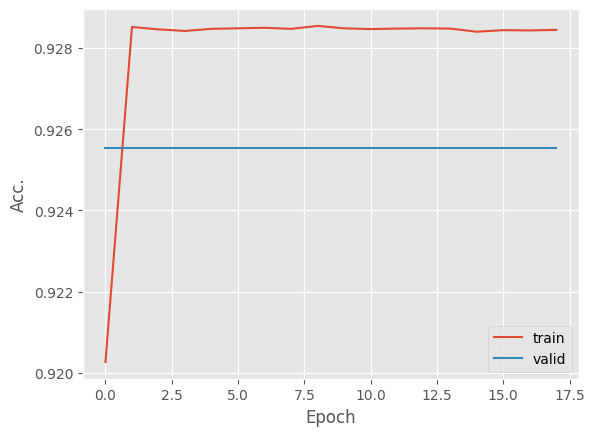

In [25]:
# Hide this cell
epochs = [x["epoch"] for x in history]
train_loss = [x["train_acc"] for x in history]
valid_loss = [x["valid_acc"] for x in history]

fig, ax = plt.subplots()
ax.plot(epochs, train_loss, label="train")
ax.plot(epochs, valid_loss, label="valid")
ax.set(xlabel="Epoch", ylabel="Acc.")
plt.legend()

## 2. Class imbalance

In the above history plot, notice how the accuracy of the model converges to a high value very quickly (>90% at the end of the first epoch). Such an odd history indicates that something could be wrong within our dataset.

### Data distribution

Let us inspect the distribution of the data using `plt.hist(train_y)`, paying special attention to the validation part (the final 20%).

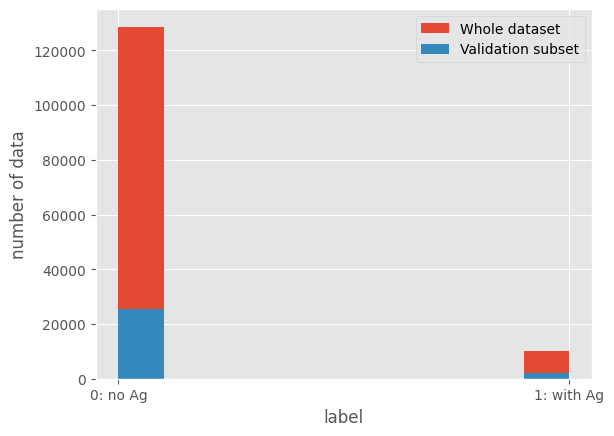

In [ ]:
# plot distribution of data
plt.figure(dpi=100)
plt.hist(train_y, label='Whole dataset')
plt.hist(train_y[-len(train_y)//5:], label='Validation subset')
plt.xticks([0, 1], ['0: no Ag', '1: with Ag'])
plt.xlabel('label')
plt.ylabel('number of data')
plt.legend()
plt.show()

The histograms show that our dataset is dominated by samples labelled 0 or "no Ag", which account for over 95% of the data. Thus, if the model simply learns to *guess* "no Ag" in every sample, it can achieve 95% accuracy without learning anything meaningful. This problem is known as **class imbalance**.

To avoid this, we must balance the classes. There are a number of strategies we can take:

* Upsample the minority class;
* Downsample the majority class;
* Change the performance metric.

The best available option for our problem is to downsample the majority class, which can be easily achieved with `numpy`:

In [26]:
# find original indices of 0 ('no Ag') and 1 ('with Ag')
id_no_Ag = np.where(train_y == 0)[0]
id_with_Ag = np.where(train_y == 1)[0]

# downsample 'no Ag' to the number of 'with Ag' by np.random.choice
id_no_Ag_downsample = np.random.choice(id_no_Ag, len(id_with_Ag))

# concatenate 'with Ag' and downsampled 'no Ag'
id_downsample = np.concatenate((id_with_Ag, id_no_Ag_downsample))

# shuffle the indices because they are ordered after concatenation
np.random.shuffle(id_downsample)

# finally get the balanced data
train_x_balanced = train_x[id_downsample]
train_y_balanced = train_y[id_downsample]

Re-exam the histograms of the balanced dataset after downsampling the majority:

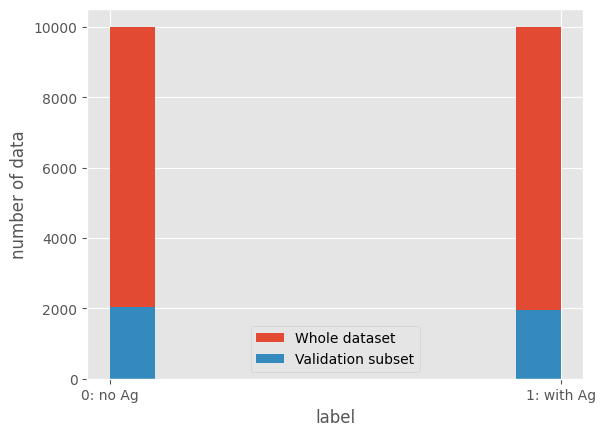

In [27]:
# plot distribution of downsampled data
plt.figure(dpi=100)
plt.hist(train_y_balanced, label='Whole dataset')
plt.hist(train_y_balanced[-len(train_y_balanced)//5:], label='Validation subset')
plt.xticks([0, 1], ['0: no Ag', '1: with Ag'])
plt.xlabel('label')
plt.ylabel('number of data')
plt.legend()
plt.show()

### Re-train the model

Now we can re-train the model with the balanced dataset. Simply change `train_x` and `train_y` to `train_x_balanced` and `train_y_balanced`  and repeat all the steps in [1. Try out a network](#1.-Try-out-a-network). A larger `epochs` (say 1000) can be used because we now have much fewer data.


**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
##### to torch ######
x_in = torch.from_numpy(train_x_balanced).type(torch.float)
y_true = torch.from_numpy(train_y_balanced).type(torch.float).unsqueeze(1)

### split into train/val ######

train_lim = int(x_in.shape[0] * 0.8)
x_in_train = x_in[:train_lim]
y_true_train = y_true[:train_lim]

x_in_val = x_in[train_lim:]
y_true_val = y_true[train_lim:]

train_data = [(x_in_train[i], y_true_train[i]) for i in range(x_in_train.shape[0])]
val_data = [(x_in_val[i], y_true_val[i]) for i in range(x_in_val.shape[0])]

BATCH_SIZE = 512

train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(val_data,
                                 batch_size=BATCH_SIZE)

EPOCHS = 1000

best_valid_loss = float('inf')
history = []

for epoch in trange(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'mlp-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    history.append({'epoch': epoch, 'epoch_time': epoch_time,
                    'valid_acc': valid_acc, 'train_acc': train_acc})

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
```
    
</p>
</details>

In [31]:
# Hide this code
##### to torch ######
x_in = torch.from_numpy(train_x_balanced).type(torch.float)
y_true = torch.from_numpy(train_y_balanced).type(torch.float).unsqueeze(1)

### split into train/val ######

train_lim = int(x_in.shape[0] * 0.8)
x_in_train = x_in[:train_lim]
y_true_train = y_true[:train_lim]

x_in_val = x_in[train_lim:]
y_true_val = y_true[train_lim:]

train_data = [(x_in_train[i], y_true_train[i]) for i in range(x_in_train.shape[0])]
val_data = [(x_in_val[i], y_true_val[i]) for i in range(x_in_val.shape[0])]

BATCH_SIZE = 512

train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(val_data,
                                 batch_size=BATCH_SIZE)

In [40]:
EPOCHS = 100

model = MLP(1000, 512)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)

best_valid_loss = float('inf')
history = []

for epoch in trange(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'mlp-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    history.append({'epoch': epoch, 'epoch_time': epoch_time,
                    'valid_acc': valid_acc, 'train_acc': train_acc})

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

  0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.961 | Train Acc: 49.80%
	 Val. Loss: 0.695 |  Val. Acc: 51.23%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.697 | Train Acc: 49.68%
	 Val. Loss: 0.695 |  Val. Acc: 49.49%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.695 | Train Acc: 49.13%
	 Val. Loss: 0.695 |  Val. Acc: 49.57%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.695 | Train Acc: 49.27%
	 Val. Loss: 0.694 |  Val. Acc: 49.67%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.695 | Train Acc: 49.58%
	 Val. Loss: 0.694 |  Val. Acc: 49.91%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.695 | Train Acc: 49.51%
	 Val. Loss: 0.694 |  Val. Acc: 49.80%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.695 | Train Acc: 49.95%
	 Val. Loss: 0.695 |  Val. Acc: 49.76%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.695 | Train Acc: 49.59%
	 Val. Loss: 0.695 |  Val. Acc: 49.90%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.695 | Train Acc: 49.82%
	 Val. Loss: 0.694 |  Val. Acc: 49.83%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 0s
	Train Loss: 0.695 | Train Acc: 49.42%
	 Val. Loss: 0.694 |  Val. Acc: 49.85%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 11 | Epoch Time: 0m 0s
	Train Loss: 0.694 | Train Acc: 49.70%
	 Val. Loss: 0.694 |  Val. Acc: 49.74%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 0s
	Train Loss: 0.695 | Train Acc: 49.84%
	 Val. Loss: 0.695 |  Val. Acc: 50.43%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 13 | Epoch Time: 0m 0s
	Train Loss: 0.694 | Train Acc: 49.88%
	 Val. Loss: 0.694 |  Val. Acc: 50.25%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 0s
	Train Loss: 0.695 | Train Acc: 49.78%
	 Val. Loss: 0.694 |  Val. Acc: 50.02%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 15 | Epoch Time: 0m 0s
	Train Loss: 0.694 | Train Acc: 50.16%
	 Val. Loss: 0.694 |  Val. Acc: 50.55%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 0s
	Train Loss: 0.694 | Train Acc: 49.80%
	 Val. Loss: 0.694 |  Val. Acc: 50.68%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 17 | Epoch Time: 0m 0s
	Train Loss: 0.694 | Train Acc: 50.24%
	 Val. Loss: 0.694 |  Val. Acc: 50.40%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 0s
	Train Loss: 0.694 | Train Acc: 50.25%
	 Val. Loss: 0.694 |  Val. Acc: 50.27%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 19 | Epoch Time: 0m 0s
	Train Loss: 0.695 | Train Acc: 49.74%
	 Val. Loss: 0.693 |  Val. Acc: 50.57%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 0s
	Train Loss: 0.694 | Train Acc: 50.48%
	 Val. Loss: 0.694 |  Val. Acc: 50.44%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 21 | Epoch Time: 0m 0s
	Train Loss: 0.694 | Train Acc: 50.31%
	 Val. Loss: 0.694 |  Val. Acc: 50.82%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 22 | Epoch Time: 0m 0s
	Train Loss: 0.694 | Train Acc: 50.37%
	 Val. Loss: 0.693 |  Val. Acc: 50.61%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 23 | Epoch Time: 0m 0s
	Train Loss: 0.694 | Train Acc: 50.81%
	 Val. Loss: 0.693 |  Val. Acc: 51.76%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 24 | Epoch Time: 0m 0s
	Train Loss: 0.694 | Train Acc: 50.55%
	 Val. Loss: 0.693 |  Val. Acc: 50.99%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 25 | Epoch Time: 0m 0s
	Train Loss: 0.694 | Train Acc: 50.26%
	 Val. Loss: 0.693 |  Val. Acc: 51.45%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 26 | Epoch Time: 0m 0s
	Train Loss: 0.694 | Train Acc: 50.95%
	 Val. Loss: 0.692 |  Val. Acc: 51.54%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 27 | Epoch Time: 0m 0s
	Train Loss: 0.693 | Train Acc: 50.94%
	 Val. Loss: 0.695 |  Val. Acc: 49.59%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 28 | Epoch Time: 0m 0s
	Train Loss: 0.694 | Train Acc: 50.49%
	 Val. Loss: 0.693 |  Val. Acc: 51.28%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 29 | Epoch Time: 0m 0s
	Train Loss: 0.693 | Train Acc: 51.39%
	 Val. Loss: 0.692 |  Val. Acc: 51.58%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 30 | Epoch Time: 0m 0s
	Train Loss: 0.693 | Train Acc: 51.01%
	 Val. Loss: 0.692 |  Val. Acc: 51.67%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 31 | Epoch Time: 0m 0s
	Train Loss: 0.693 | Train Acc: 50.93%
	 Val. Loss: 0.692 |  Val. Acc: 51.77%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 32 | Epoch Time: 0m 0s
	Train Loss: 0.693 | Train Acc: 51.39%
	 Val. Loss: 0.692 |  Val. Acc: 52.46%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 33 | Epoch Time: 0m 0s
	Train Loss: 0.692 | Train Acc: 51.82%
	 Val. Loss: 0.691 |  Val. Acc: 52.00%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 34 | Epoch Time: 0m 0s
	Train Loss: 0.692 | Train Acc: 51.85%
	 Val. Loss: 0.691 |  Val. Acc: 52.65%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 35 | Epoch Time: 0m 0s
	Train Loss: 0.692 | Train Acc: 51.67%
	 Val. Loss: 0.692 |  Val. Acc: 52.56%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 36 | Epoch Time: 0m 0s
	Train Loss: 0.691 | Train Acc: 52.66%
	 Val. Loss: 0.691 |  Val. Acc: 52.98%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 37 | Epoch Time: 0m 0s
	Train Loss: 0.691 | Train Acc: 52.84%
	 Val. Loss: 0.692 |  Val. Acc: 51.98%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 38 | Epoch Time: 0m 0s
	Train Loss: 0.691 | Train Acc: 52.73%
	 Val. Loss: 0.691 |  Val. Acc: 53.57%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 39 | Epoch Time: 0m 0s
	Train Loss: 0.691 | Train Acc: 52.86%
	 Val. Loss: 0.692 |  Val. Acc: 51.15%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 40 | Epoch Time: 0m 0s
	Train Loss: 0.690 | Train Acc: 53.12%
	 Val. Loss: 0.689 |  Val. Acc: 54.46%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 41 | Epoch Time: 0m 0s
	Train Loss: 0.690 | Train Acc: 53.77%
	 Val. Loss: 0.691 |  Val. Acc: 52.35%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 42 | Epoch Time: 0m 0s
	Train Loss: 0.689 | Train Acc: 53.64%
	 Val. Loss: 0.689 |  Val. Acc: 55.20%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 43 | Epoch Time: 0m 0s
	Train Loss: 0.688 | Train Acc: 54.53%
	 Val. Loss: 0.689 |  Val. Acc: 52.51%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 44 | Epoch Time: 0m 0s
	Train Loss: 0.689 | Train Acc: 53.58%
	 Val. Loss: 0.689 |  Val. Acc: 52.01%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 45 | Epoch Time: 0m 0s
	Train Loss: 0.688 | Train Acc: 54.10%
	 Val. Loss: 0.689 |  Val. Acc: 53.87%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 46 | Epoch Time: 0m 0s
	Train Loss: 0.688 | Train Acc: 55.27%
	 Val. Loss: 0.688 |  Val. Acc: 53.94%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 47 | Epoch Time: 0m 0s
	Train Loss: 0.689 | Train Acc: 53.31%
	 Val. Loss: 0.686 |  Val. Acc: 57.65%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 48 | Epoch Time: 0m 0s
	Train Loss: 0.686 | Train Acc: 55.94%
	 Val. Loss: 0.687 |  Val. Acc: 54.56%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 49 | Epoch Time: 0m 0s
	Train Loss: 0.686 | Train Acc: 55.93%
	 Val. Loss: 0.685 |  Val. Acc: 56.92%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 50 | Epoch Time: 0m 0s
	Train Loss: 0.685 | Train Acc: 56.52%
	 Val. Loss: 0.684 |  Val. Acc: 55.55%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 51 | Epoch Time: 0m 0s
	Train Loss: 0.685 | Train Acc: 55.62%
	 Val. Loss: 0.683 |  Val. Acc: 59.69%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 52 | Epoch Time: 0m 0s
	Train Loss: 0.683 | Train Acc: 58.25%
	 Val. Loss: 0.682 |  Val. Acc: 60.39%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 53 | Epoch Time: 0m 0s
	Train Loss: 0.682 | Train Acc: 57.56%
	 Val. Loss: 0.684 |  Val. Acc: 54.24%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 54 | Epoch Time: 0m 0s
	Train Loss: 0.682 | Train Acc: 56.30%
	 Val. Loss: 0.680 |  Val. Acc: 58.75%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 55 | Epoch Time: 0m 0s
	Train Loss: 0.679 | Train Acc: 59.88%
	 Val. Loss: 0.679 |  Val. Acc: 57.49%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 56 | Epoch Time: 0m 0s
	Train Loss: 0.678 | Train Acc: 59.00%
	 Val. Loss: 0.685 |  Val. Acc: 51.40%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 57 | Epoch Time: 0m 0s
	Train Loss: 0.678 | Train Acc: 58.28%
	 Val. Loss: 0.677 |  Val. Acc: 59.08%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 58 | Epoch Time: 0m 0s
	Train Loss: 0.675 | Train Acc: 61.39%
	 Val. Loss: 0.674 |  Val. Acc: 62.71%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 59 | Epoch Time: 0m 0s
	Train Loss: 0.673 | Train Acc: 61.79%
	 Val. Loss: 0.673 |  Val. Acc: 61.86%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 60 | Epoch Time: 0m 0s
	Train Loss: 0.673 | Train Acc: 60.02%
	 Val. Loss: 0.673 |  Val. Acc: 57.24%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 61 | Epoch Time: 0m 0s
	Train Loss: 0.670 | Train Acc: 60.36%
	 Val. Loss: 0.669 |  Val. Acc: 61.54%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 62 | Epoch Time: 0m 0s
	Train Loss: 0.668 | Train Acc: 60.14%
	 Val. Loss: 0.691 |  Val. Acc: 49.49%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 63 | Epoch Time: 0m 0s
	Train Loss: 0.670 | Train Acc: 59.96%
	 Val. Loss: 0.664 |  Val. Acc: 64.27%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 64 | Epoch Time: 0m 0s
	Train Loss: 0.664 | Train Acc: 62.59%
	 Val. Loss: 0.664 |  Val. Acc: 62.40%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 65 | Epoch Time: 0m 0s
	Train Loss: 0.662 | Train Acc: 62.18%
	 Val. Loss: 0.662 |  Val. Acc: 62.56%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 66 | Epoch Time: 0m 0s
	Train Loss: 0.658 | Train Acc: 64.44%
	 Val. Loss: 0.658 |  Val. Acc: 64.46%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 67 | Epoch Time: 0m 0s
	Train Loss: 0.654 | Train Acc: 65.03%
	 Val. Loss: 0.657 |  Val. Acc: 62.43%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 68 | Epoch Time: 0m 0s
	Train Loss: 0.651 | Train Acc: 66.36%
	 Val. Loss: 0.650 |  Val. Acc: 67.05%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 69 | Epoch Time: 0m 0s
	Train Loss: 0.646 | Train Acc: 66.98%
	 Val. Loss: 0.650 |  Val. Acc: 63.44%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 70 | Epoch Time: 0m 0s
	Train Loss: 0.644 | Train Acc: 65.61%
	 Val. Loss: 0.643 |  Val. Acc: 68.02%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 71 | Epoch Time: 0m 0s
	Train Loss: 0.637 | Train Acc: 67.62%
	 Val. Loss: 0.654 |  Val. Acc: 57.31%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 72 | Epoch Time: 0m 0s
	Train Loss: 0.640 | Train Acc: 63.91%
	 Val. Loss: 0.635 |  Val. Acc: 67.94%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 73 | Epoch Time: 0m 0s
	Train Loss: 0.630 | Train Acc: 68.24%
	 Val. Loss: 0.638 |  Val. Acc: 63.06%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 74 | Epoch Time: 0m 0s
	Train Loss: 0.625 | Train Acc: 68.45%
	 Val. Loss: 0.624 |  Val. Acc: 71.05%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 75 | Epoch Time: 0m 0s
	Train Loss: 0.625 | Train Acc: 66.75%
	 Val. Loss: 0.620 |  Val. Acc: 69.70%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 76 | Epoch Time: 0m 0s
	Train Loss: 0.616 | Train Acc: 69.14%
	 Val. Loss: 0.617 |  Val. Acc: 69.00%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 77 | Epoch Time: 0m 0s
	Train Loss: 0.607 | Train Acc: 70.99%
	 Val. Loss: 0.608 |  Val. Acc: 71.78%


Training:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


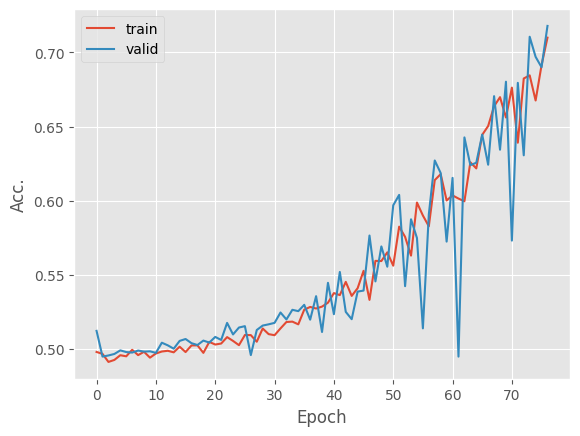

In [41]:
# Hide this cell
epochs = [x["epoch"] for x in history]
train_loss = [x["train_acc"] for x in history]
valid_loss = [x["valid_acc"] for x in history]

fig, ax = plt.subplots()
ax.plot(epochs, train_loss, label="train")
ax.plot(epochs, valid_loss, label="valid")
ax.set(xlabel="Epoch", ylabel="Acc.")
plt.legend()

---

## Exercises

Build a DNN to detect the presence of all the elements. To do this, you may go through the following steps:

1. Find all the elements appearing in the dataset; the answer will be `['Zn', 'Sb', 'Si', 'Fe', 'Ag', 'Cu', 'Bi']`.
2. Balance the dataset: if one of the elements appears much less times than the others, it is better to ignore it. Doing everything correctly, you will find the number of samples containing each element as shown in the following table. Therefore, we may ignore Ag in this network.


|  Element | # Samples |
|---|---|
|Zn| 51174|  
|Sb| 51132|  
|Si| 50909|
|Fe| 50764|
|Ag| 10000|
|Cu| 50945|
|Bi| 50784|
    
3. Do one-hot encoding for the element list `['Zn', 'Sb', 'Si', 'Fe', 'Cu', 'Bi']`; if a sample contains Fe and Sb, e.g., the one-hot vector for this sample will be `[0, 1, 0, 1, 0, 0]`.
4. Build and train a DNN (with an output size of 6) to detect the presence of the six elements.

If doing everything correctly, you will find that the overall accuracy is around 60%. However, the model is not garbage. If we evaluate the accuracy for each element, we will find that the accracy for some of elements is nearly 0 while for the others nearly 100%. This means the dataset is agnostic to these elements, which lower the overall accuracy, but the model can still be used to predict the other elements with  high accuracy.

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
n/a TODO
    
</p>
</details>